In [113]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, mean_squared_error

## Clasificación

### I. Carga del dataset Wine


In [114]:
wine_dataset = load_wine()
df_wine = pd.DataFrame(data=np.c_[wine_dataset['data'], wine_dataset['target']], columns=wine_dataset['feature_names'] + ['targets'])
df_wine

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,targets
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0



### II. Seleccion de las caracteristicas Alcohol, magnesium y color intensity

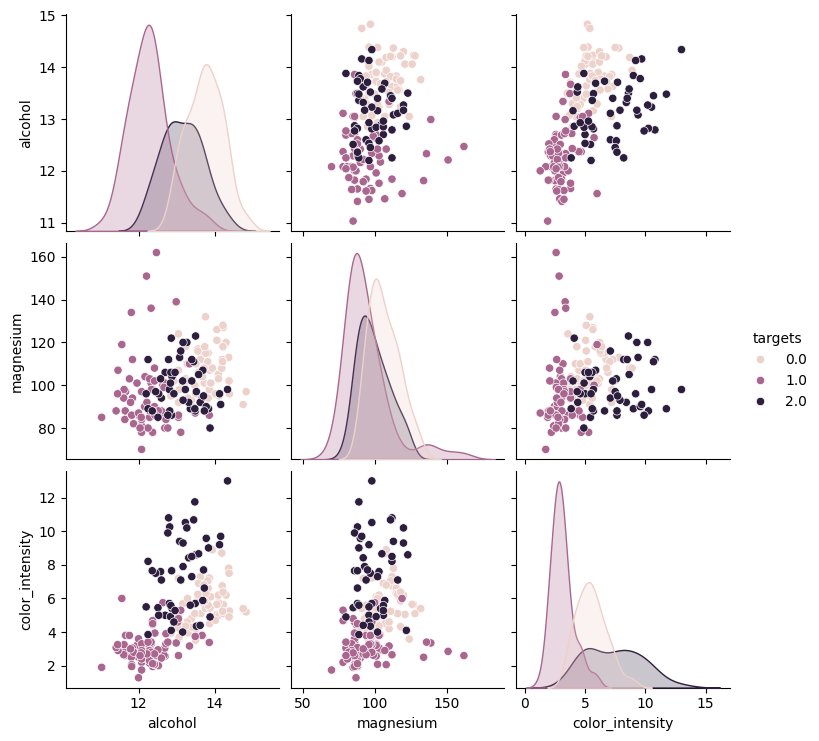

In [115]:
data = df_wine[['alcohol', 'magnesium', 'color_intensity', 'targets']]

sns.pairplot(data, hue='targets')

### III. Se seleccionan dos tipos de vino linealmente separables

A partir de los graficos, se seleccionan las clases 0 y 1 que, con las caracteristicas seleccionadas, son linealmente separables


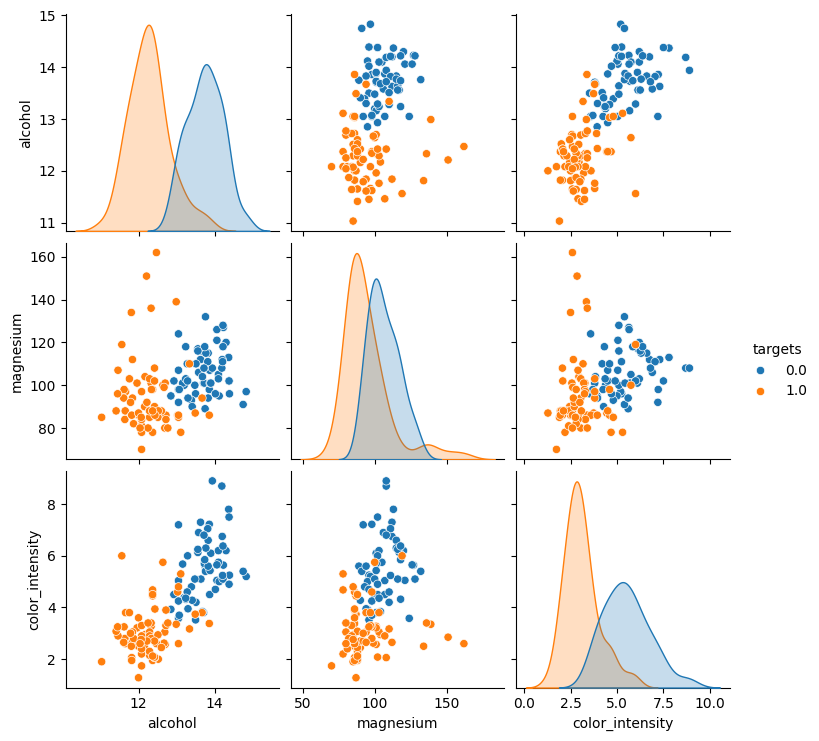

In [116]:
target = 2.0

data_filtered = data[data['targets'] != target]

sns.pairplot(data_filtered, hue='targets')

In [117]:

X = np.array([[row['alcohol'],row['magnesium'],row['color_intensity']] for _, row in data_filtered.iterrows()])
Y = np.array([row['targets'] for _, row in data_filtered.iterrows()])

# Se normalizan los datos
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)


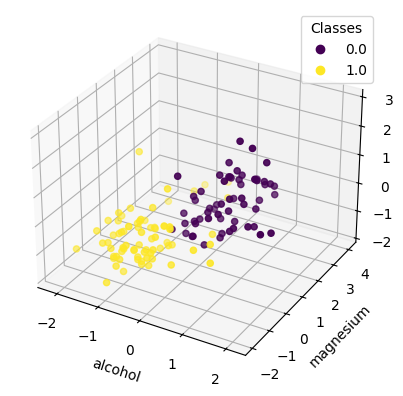

In [118]:
# Graficamos los puntos, se ve aun mejor que son linealmente separables
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_std[:, 0], X_std[:, 1], X_std[:, 2], c=Y)
ax.set(xlabel='alcohol', ylabel='magnesium', zlabel='color_intensity')
ax.legend(scatter.legend_elements()[0], np.unique(data_filtered['targets']), loc='upper right', title="Classes")
plt.show()


### IV. Division de la data en entrenamiento y evaluación

In [119]:
x_train, x_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.33, shuffle=True)

### V.Implementacion de Perceptron Simple para clasificación binaria

Se calcula la propagación **hacia delante** en donde cada peso se multiplica por la entrada. El valor de cada peso representa lo importante de cada característica en la predicción. Para el cálculo de la propagación hacia delante se realizan las siguiente operaciones
La función de activación:
$$
\phi(z) = \begin{cases}
1 & z \geq 0 \\
0 & z < 0
\end{cases} \\
ó\\
\phi(z) = z \\
$$
Para la clasificacion binaria se utilizara la primera funcion de activación, l


z es una regresion lineal, donde cada w es un peso para cada x de entrada
\
$$
z = w_1x_1 + w_2x_2 + \ldots + w_nx_n + b
$$

Luego, se calcula la **propagación hacia detrás** derivando la función de costo (error cuadratico medio) con respecto a cada uno de los pesos.

$$
\frac{\partial E}{\partial w_{ij}} = \frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z_i} \frac{\partial z_i}{\partial w_{ij}}
$$

De modo que se ajustan los pesos, mientras mayor sea el error, se realiza un mayor ajuste:
$$
w_{ij}^{nueva} = w_{ij}^{antigua} - \alpha \frac{\partial E}{\partial w_{ij}}
$$

In [120]:
class ActivationFunction:
    f = None
    df = None

    def __init__(self, f, df):
        self.f = f
        self.df = df

    def activate(self,x):
        return self.f(x)

    def derivative(self,x):
        return self.df(x)

# Implementación propia del perceptron
class Perceptron:

    W = None
    b = 0
    f_activation : ActivationFunction = None

    def __init__(self, input_shape=1, activation='identity'):
        if ( not isinstance(input_shape, int) ):
            raise Exception(f'input_shape must be an integer, given {type(input_shape)}')
        # Los pesos y bias son inicializados, input_shape indica el numero de
        # neuronas en la capa de entrada
        self.W = np.array([random.uniform(0.01, 0.1) for _ in range(input_shape)])
        self.b = random.uniform(0.01, 0.1)
        self.f_activation=  self.__activation_parser(activation)

    # Parsea por la función la función de activación correspondiente
    def __activation_parser(self, activation):
        match(activation):
            # Función de activación para realizar la regresión lineal
            case "identity":
                func = lambda x : 1 * x
                d_func = lambda x : x * 1
            # Función de activación para realizar la clasificación
            case "conditional":
                func = lambda x : 1 if (x > 0) else 0
                d_func = lambda x : x * 1
            case _:
                raise Exception(f'activation must be identity or conditional, given {activation}')
        return ActivationFunction(func, d_func)

    # Calcula la propagación hacia adelante
    def __feedfoward_prop(self, X):
        # Calculamos la regresión lineal, multiplicando los datos de entrada
        # por los pesos correspondientes y aplicamos la funcion de activacion
        lineal_regression_result = np.dot(X, self.W.T) + self.b
        return self.f_activation.activate(lineal_regression_result)

    # Propagación hacia atras ajustando los valores de w y el valor de b
    def __backward_prop(self, X, Y_pred, Y, alpha):
        W_next = np.copy(self.W)
        b_next = self.b
        # Ajustamos cada peso
        for i in range(W_next.shape[0]):
            # mientras más elevado sea el error, un ajuste mayor se realiza
            W_next[i] += alpha * ( Y - Y_pred ) * X[i]
        # Ajustamos el bias
        b_next = b_next + alpha * ( Y - Y_pred )
        return (W_next, b_next)

    def __calculate_loss_squared(self, y_pred, y):
        return (y - y_pred)**2

    def get_weights(self):
        return (self.W, self.b)

    def fit(self,X,Y,epochs=2, alpha=0.5, verbose = False):
        if ( not isinstance(X, np.ndarray) or not isinstance(Y, np.ndarray)):
            raise Exception(f'X and Y must be a numpy array, given {type(X)} {type(Y)}')
        # Arreglo para guardar los errores por época
        history = np.zeros(epochs)
        for epoch in range(epochs):
            error = np.zeros(X.shape[0])
            # Por cada punto, se calcula la propagación hacia delante
            # y la propagación hacia atrás
            for n_sample, sample in enumerate(X):
                y = Y[n_sample]
                y_pred = self.__feedfoward_prop(sample)
                self.W, self.b = self.__backward_prop(sample, y_pred, y, alpha)
                error[n_sample] = self.__calculate_loss_squared(y_pred, y)
            # calculamos el error cuadratico medio mediante los errores obtenidos
            mean_square_error = sum(error) / n_sample
            if ( verbose ):
                print(f"Epoch {epoch + 1}/{epochs} loss: {mean_square_error}")
            history[epoch] = mean_square_error
        return history

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        # Para las predicciones se calcula la propagación hacia delante de
        # cada dato
        for i, row in enumerate(X):
            y_pred[i] = self.__feedfoward_prop(row)
        return y_pred



### VI. Entrenamiento
Para el entrenamiento se escogera la función de activación
$$
\phi(z) = \begin{cases}
1 & z \geq 0 \\
0 & z < 0
\end{cases} \\
$$

In [121]:
model = Perceptron(input_shape=3, activation='conditional')

model.fit(x_train, y_train, epochs=1500, alpha=0.014)

y_pred_own = model.predict(x_test)

### VI.a Graficamos el plano de separacion con los pesos

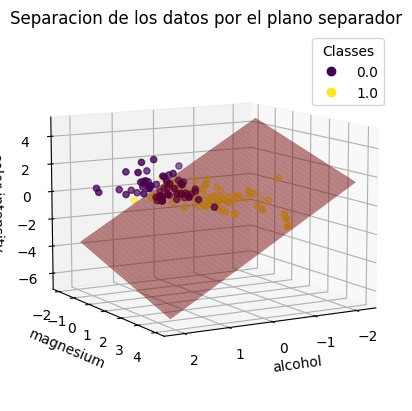

In [122]:
# Intervalo X
ax = np.min(x_train[:,0])
bx = np.max(x_train[:,0])
# Intervalo Y
ay = np.min(x_train[:,1])
by = np.max(x_train[:,1])
muestras = 100

(weights, bias) = model.get_weights()
# gráfica del plano separador
xi = np.linspace(ax,bx, muestras)
yi = np.linspace(ay,by, muestras)
Xi, Yi = np.meshgrid(xi,yi)
z = lambda x,y: (-weights[0]*x - weights[1]*y + bias)/weights[2]
Z0 = z(Xi,Yi)

figura = plt.figure()
ax = figura.add_subplot(111, projection='3d')
scatter = ax.scatter(X_std[:, 0], X_std[:, 1], X_std[:, 2], c=Y)
ax.plot_surface(Xi,Yi,Z0,color ='red',label='Pendiente', alpha = 0.5)
ax.set_title('Separacion de los datos por el plano separador')
ax.set_xlabel('alcohol')
ax.set_ylabel('magnesium')
ax.set_zlabel('color intensity')
ax.legend(scatter.legend_elements()[0], np.unique(data_filtered['targets']), loc='upper right', title="Classes")
# rotacion de ejes
ax.view_init(10,60)
plt.show()

### VII. Comparamos con la implementación de SKlearn

Se puede observar que la implementación propia tiene un desempeño similar comparada con la del modulo sklearn

Reporte de implementación propia
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93        21
         1.0       0.91      0.95      0.93        22

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43

Reporte de implementación sklearn
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89        21
         1.0       0.85      1.00      0.92        22

    accuracy                           0.91        43
   macro avg       0.92      0.90      0.91        43
weighted avg       0.92      0.91      0.91        43



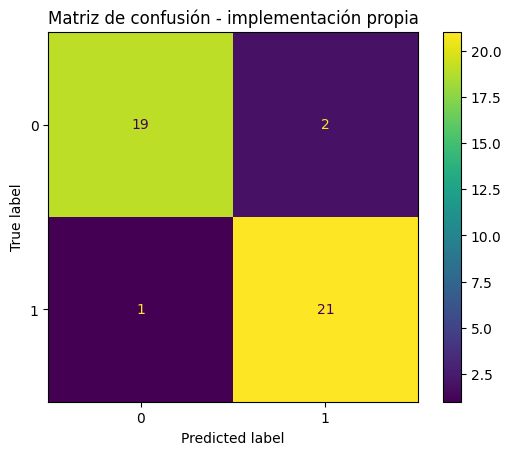

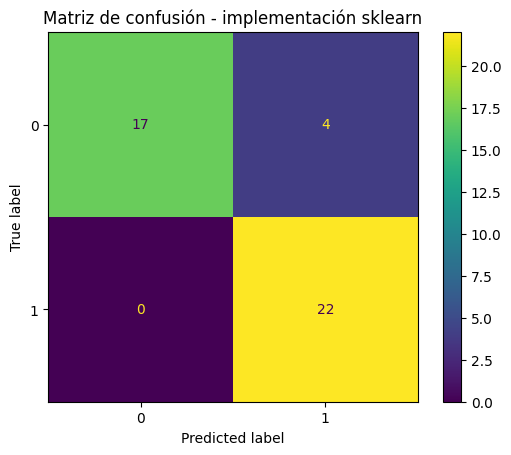

In [123]:
# Instanciación, entrenamineto y predicción del modelo de sklearn
clf = SklearnPerceptron(tol=1e-3, random_state=0)
clf.fit(x_train, y_train)
y_pred_sklearn = clf.predict(x_test)

# Mostramos los reportes de clasificación de la implementación propia
# y de sklearn
print("Reporte de implementación propia")
print(classification_report(y_test, y_pred_own))
print("Reporte de implementación sklearn")
print(classification_report(y_test, y_pred_sklearn))

# Mostramos las matrices de confusión de ambas implementaciones
own_matrix = confusion_matrix(y_test, y_pred_own)
sklearn_matrix = confusion_matrix(y_test, y_pred_sklearn)

ownMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=own_matrix,
    display_labels=["0", "1"],
)
ownMatrixDisplay.plot()
plt.title("Matriz de confusión - implementación propia")
plt.show()
sklearnMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=sklearn_matrix, display_labels=["0", "1"]
)
sklearnMatrixDisplay.plot()
plt.title("Matriz de confusión - implementación sklearn")
plt.show()

## Regresión

Para los problemas de regresión, usaremos la misma implementación solo que le indicaremos la funcion de activación a usar es la de **identidad**.

### I. Cargamos los datos y los dividimos en entrenamieneto y evaluación

In [124]:

score_dataset = pd.read_csv('./dataset/score.csv')
# Nuestra X seran las horas y las Y los puntajes
X = np.array([[row['Hours']] for _, row in score_dataset.iterrows()])
Y = np.array([[row['Scores']] for _, row in score_dataset.iterrows()])
# Separamos los datos de entrenamiento de los de evaluación
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

### II. Graficamos y observamos que se trata de un problema lineal

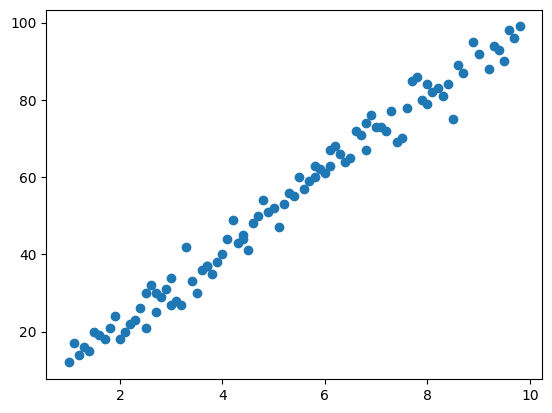

In [125]:
plt.plot(X,Y, 'o')

### III. Instanciación del modelo, entrenamiento y predicción

In [126]:
model = Perceptron(input_shape=1, activation='identity')
history = model.fit(x_train, y_train, epochs=25, alpha=0.0010, verbose=False)
y_pred_own = model.predict(x_test)

In [127]:
reg = LinearRegression().fit(x_train, y_train)
y_pred_sklearn = reg.predict(x_test)

### IV. Graficamos la recta con los pesos obtenidos

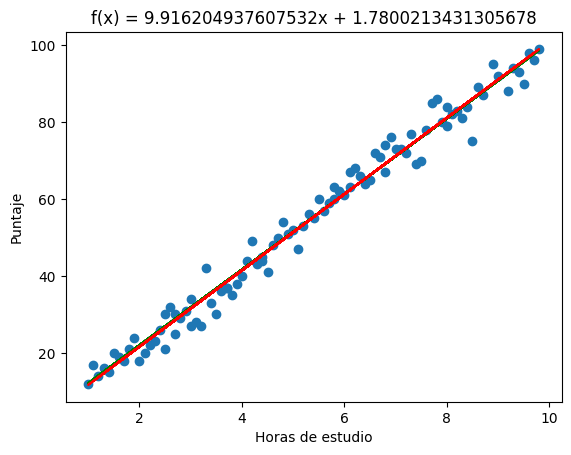

In [128]:
def f(x, model):
    w = model.get_weights()
    return x * w[0] + w[1]

def f_sklearn(x, coef, intercept):
    return x * coef + intercept

plt.title(f"f(x) = {model.get_weights()[0][0]}x + {model.get_weights()[1][0]}")
plt.xlabel("Horas de estudio")
plt.ylabel("Puntaje")
plt.plot(X,Y, 'o')
plt.plot(X, f_sklearn(X, reg.coef_,reg.intercept_), color = 'green')
plt.plot(X, f(X, model), color = 'red')

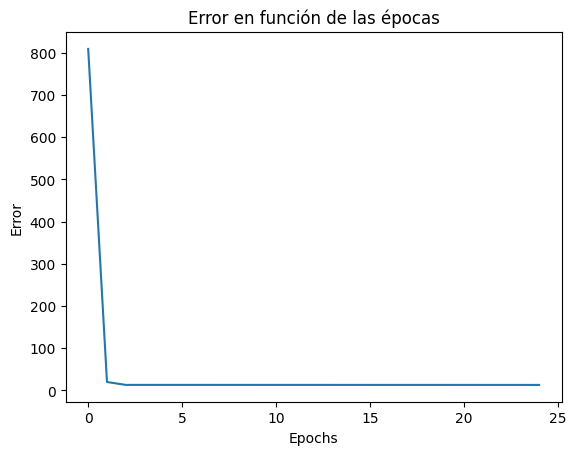

In [129]:
# Gráfica del error
plt.title("Error en función de las épocas")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(range(len(history)), history)

### V. Mostramos el error

In [130]:


print("Error cuadrático implementación propia",mean_squared_error(y_test, y_pred_own))
print("Error cuadrático implementación sklearn",mean_squared_error(y_test, y_pred_sklearn))


Error cuadrático implementación propia 9.803552922196904
Error cuadrático implementación sklearn 10.084803926815926
